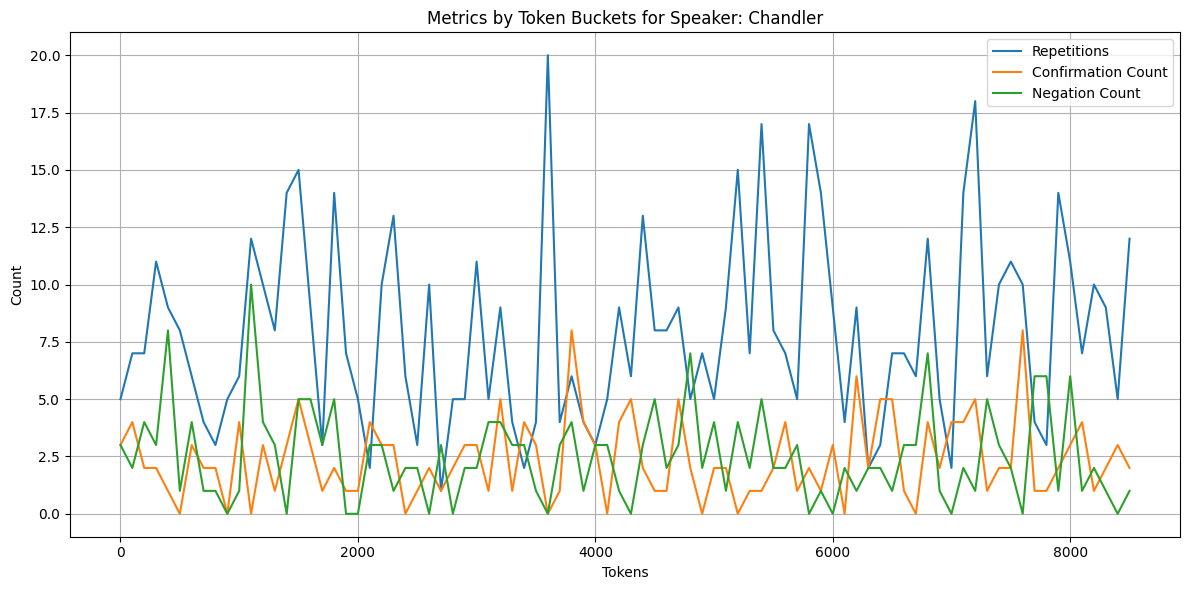

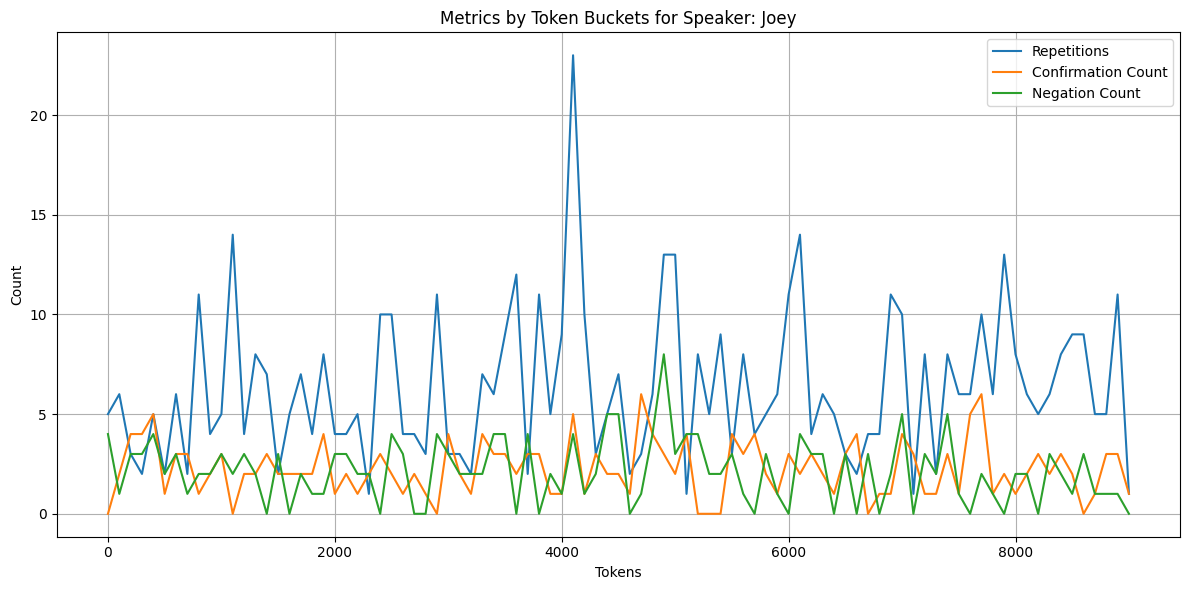

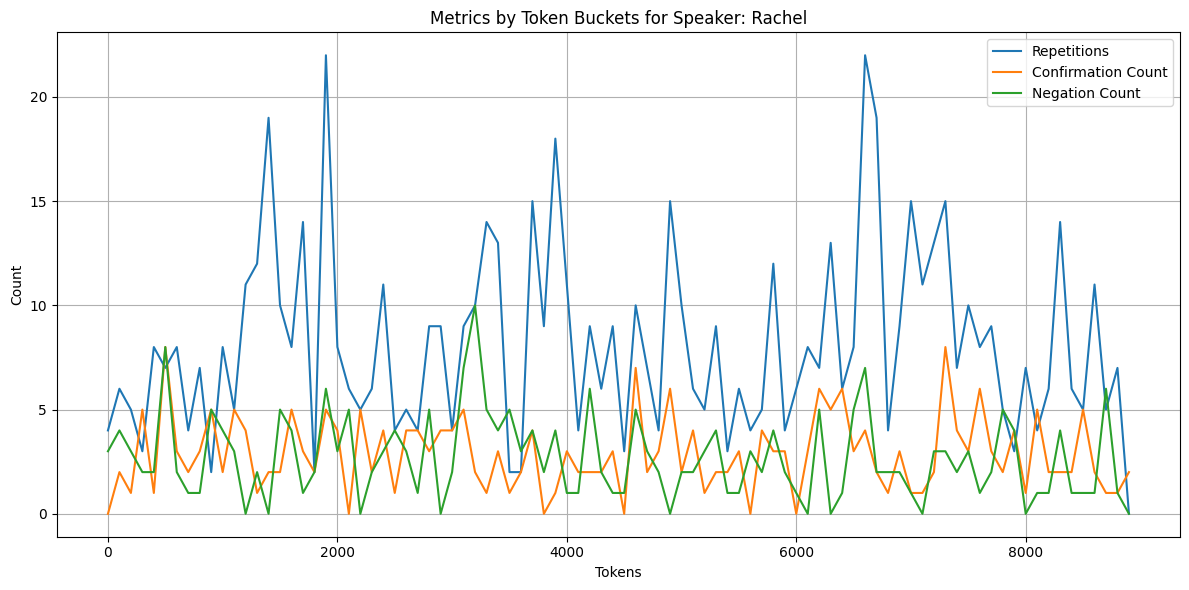

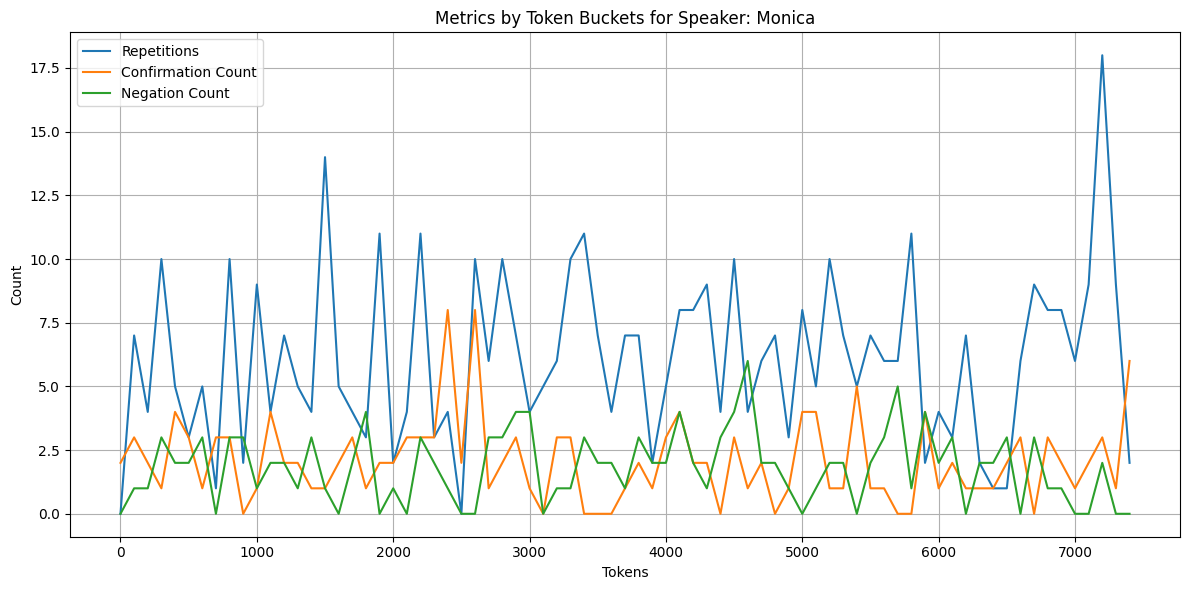

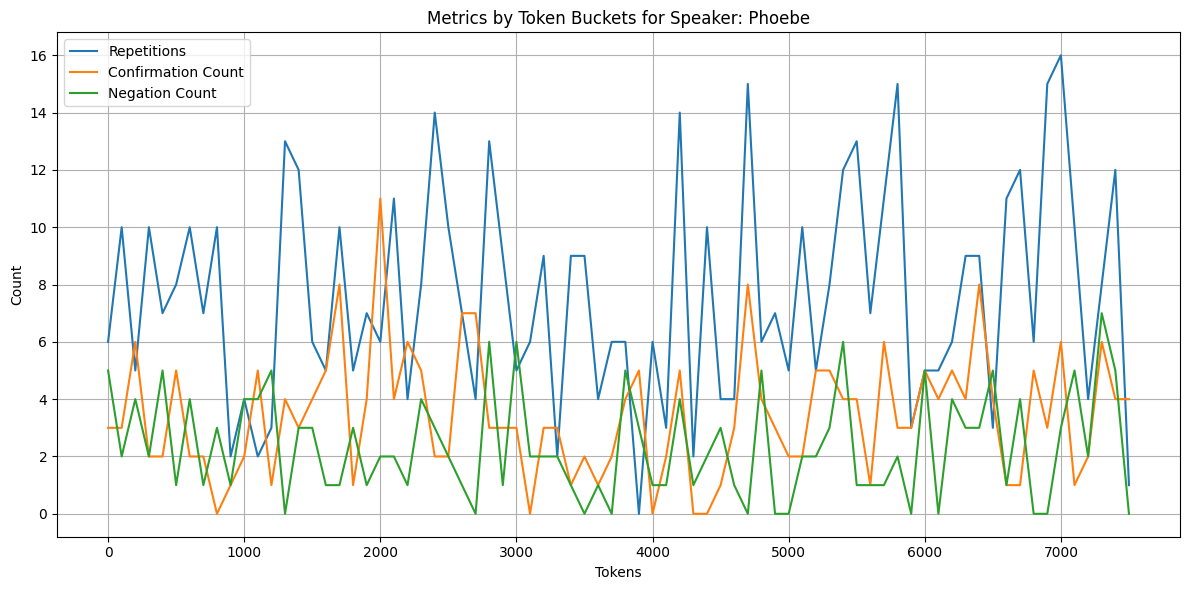

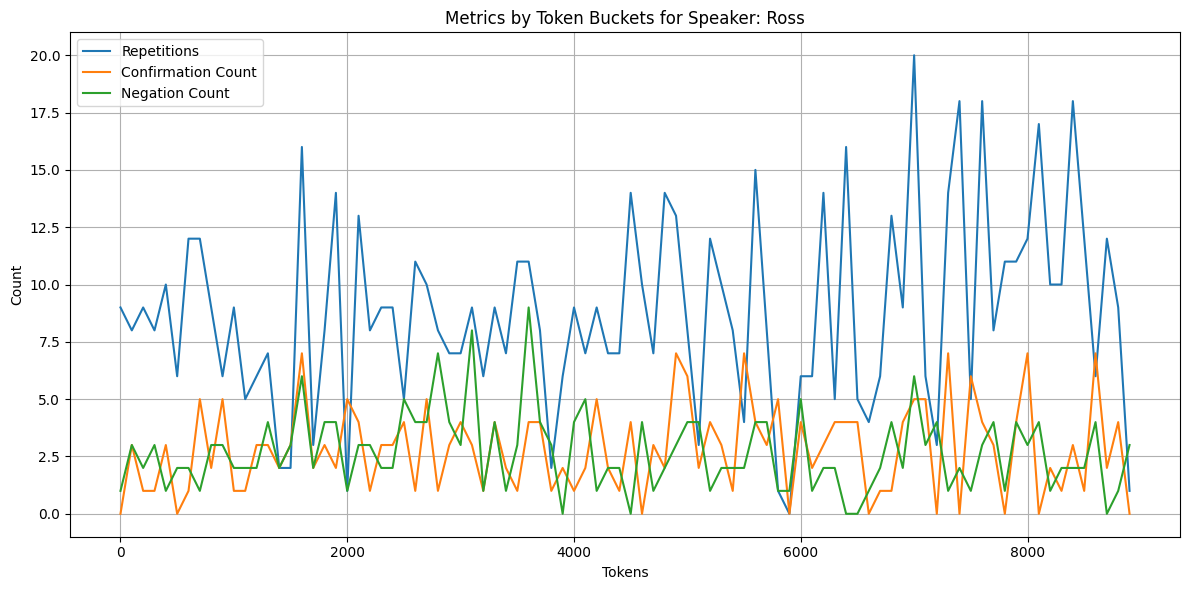

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import numpy as np

# Define your words sets
confirmation_words = {'ok', 'yes', 'yeah', 'yep', 'okay', 'alright', 'sure', 'absolutely', 'certainly', 'of course', 'indeed', 'definitely'}
negation_words = {'no', 'not', 'never', 'none', 'nor', 'nobody', 'neither', "don't", "isn't", "wasn't", "weren't", "doesn't", "won't", "haven't",  "don", "isn", "wasn", "weren", "doesn", "won", "haven"}
stop_words = {'the', 't', 's', 'a', 'to', 'is', 'and'}

def preprocess(tokens):
    return [
        token.translate(str.maketrans('', '', string.punctuation)).lower()
        for token in tokens if token not in stop_words
    ]

def calculate_row_metrics(speaker_df):
    # Metrics per row
    all_tokens = []
    token_sizes = []
    repetitions = []
    confirmation_counts = []
    negation_counts = []

    for _, row in speaker_df.iterrows():
        tokens = row['Utterance_1'].split()
        tokens = preprocess(tokens)
        all_tokens.append(tokens)

        # Token size
        token_size = len(tokens)
        token_sizes.append(token_size)

        # Word counts
        word_counts = Counter(tokens)
        
        # Calculations
        repetition_count = sum(count - 1 for word, count in word_counts.items() if count > 1)
        repetitions.append(repetition_count)

        confirmation_count = sum(count for word, count in word_counts.items() if word in confirmation_words)
        confirmation_counts.append(confirmation_count)

        negation_count = sum(count for word, count in word_counts.items() if word in negation_words)
        negation_counts.append(negation_count)

    speaker_df['Tokens'] = all_tokens
    speaker_df['Token Size'] = token_sizes
    speaker_df['Repetitions'] = repetitions
    speaker_df['Confirmation Count'] = confirmation_counts
    speaker_df['Negation Count'] = negation_counts

    return speaker_df

def calculate_bucket_metrics(speaker_df, bucket_size=100):
    # Cumulative token counter
    cumulative_tokens = 0
    bucket_metrics = {
        'Bucket': [],
        'Repetitions': [],
        'Confirmation Count': [],
        'Negation Count': []
    }
    
    current_bucket = 0
    bucket_repetitions = 0
    bucket_confirmations = 0
    bucket_negations = 0

    for _, row in speaker_df.iterrows():
        # Get counts for this utterance
        token_size = row['Token Size']
        cumulative_tokens += token_size

        # If we're in the same bucket, keep adding
        while cumulative_tokens > (current_bucket + 1) * bucket_size:
            # Save current bucket metrics
            bucket_metrics['Bucket'].append(current_bucket * bucket_size)
            bucket_metrics['Repetitions'].append(bucket_repetitions)
            bucket_metrics['Confirmation Count'].append(bucket_confirmations)
            bucket_metrics['Negation Count'].append(bucket_negations)
            
            # Reset metrics for the next bucket
            current_bucket += 1
            bucket_repetitions = 0
            bucket_confirmations = 0
            bucket_negations = 0

        # Add current row metrics to current bucket
        bucket_repetitions += row['Repetitions']
        bucket_confirmations += row['Confirmation Count']
        bucket_negations += row['Negation Count']

    # Add last bucket if not empty
    if bucket_repetitions > 0 or bucket_confirmations > 0 or bucket_negations > 0:
        bucket_metrics['Bucket'].append(current_bucket * bucket_size)
        bucket_metrics['Repetitions'].append(bucket_repetitions)
        bucket_metrics['Confirmation Count'].append(bucket_confirmations)
        bucket_metrics['Negation Count'].append(bucket_negations)
    
    return pd.DataFrame(bucket_metrics)

def calculate_metrics(speaker_df):

    tokens = [token for sublist in speaker_df['Tokens'].values for token in sublist]
    total_tokens = len(tokens)
    
    vocabulary_set = set(tokens)
    vocabulary_size = len(vocabulary_set)

    total_repetitions = sum(speaker_df['Repetitions'].values)
    total_confirmations = sum(speaker_df['Confirmation Count'].values)
    total_negations = sum(speaker_df['Negation Count'].values)
    
    metrics = {}
    metrics['Vocabulary Size'] = vocabulary_size
    metrics['Total Tokens'] = total_tokens
    metrics['Total Repetitions'] = total_repetitions
    metrics['Total Confirmations'] = total_confirmations
    metrics['Total Negations'] = total_negations
    
    return metrics

def calculate_average_personality(speaker_df):
    personality_columns = ['Personality']
    averages = {trait: eval(speaker_df[trait].iloc[0]) for trait in personality_columns}
    return averages

# Load your data
df = pd.read_csv('Dyadic_PELD.tsv', sep='\t', header=0)

# Create a dictionary of DataFrames with each subset being a copy of the relevant data
speakers = df['Speaker_1'].unique()
speaker_dfs = {speaker: df[df['Speaker_1'] == speaker].copy() for speaker in speakers}

all_metrics = {}
all_personality_averages = {}

# Process and plot metrics for each speaker
for speaker, speaker_df in speaker_dfs.items():
    speaker_df = calculate_row_metrics(speaker_df)
    bucket_df = calculate_bucket_metrics(speaker_df)
    metrics = calculate_metrics(speaker_df)
    all_metrics[speaker] = metrics

    personality_avg = calculate_average_personality(speaker_df)
    all_personality_averages[speaker] = personality_avg

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(bucket_df['Bucket'], bucket_df['Repetitions'], label='Repetitions')
    plt.plot(bucket_df['Bucket'], bucket_df['Confirmation Count'], label='Confirmation Count')
    plt.plot(bucket_df['Bucket'], bucket_df['Negation Count'], label='Negation Count')
    
    plt.title(f'Metrics by Token Buckets for Speaker: {speaker}')
    plt.xlabel('Tokens')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df_metrics = pd.DataFrame(all_metrics).T

In [2]:
df_metrics

,Vocabulary Size,Total Tokens,Total Repetitions,Total Confirmations,Total Negations
Chandler,1621,9531,830,186,169
Joey,1621,9940,730,194,154
Rachel,1429,9750,854,229,195
Monica,1492,8182,562,141,112
Phoebe,1479,8273,681,233,149
Ross,1557,9829,936,222,196


In [8]:
df_metrics

,Vocabulary Size,Total Tokens,Total Repetitions,Total Confirmations,Total Negations
Chandler,1620,8587,679,204,216
Joey,1621,9018,576,204,193
Rachel,1429,8923,733,259,241
Monica,1492,7448,457,155,136
Phoebe,1479,7511,576,261,180
Ross,1557,8961,789,254,242


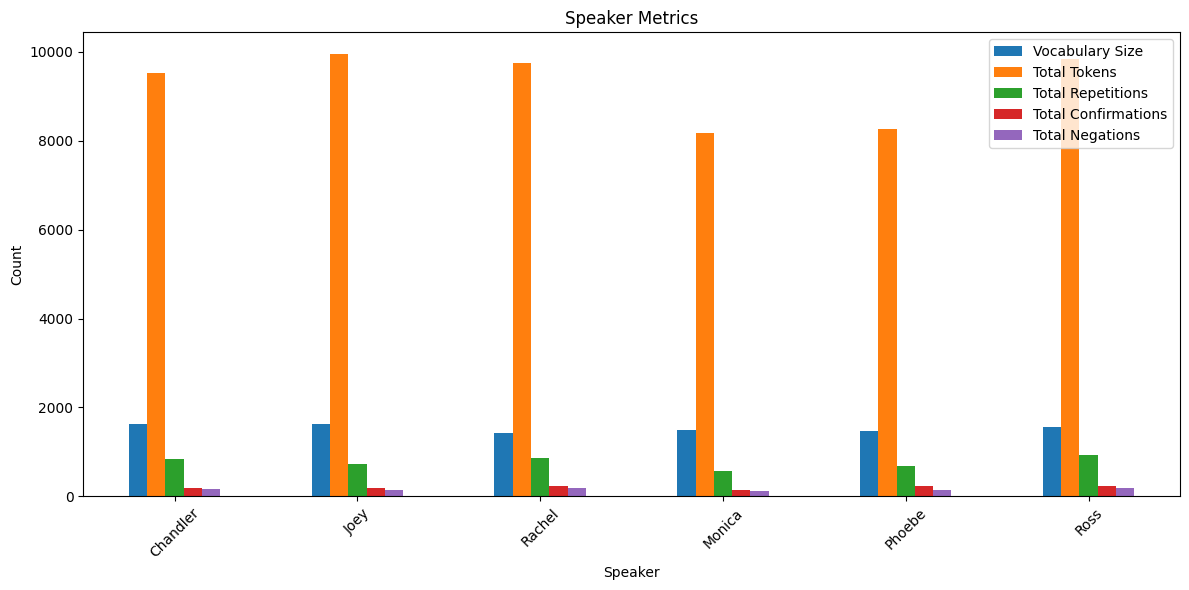

In [3]:
df_metrics.plot(kind='bar', figsize=(12, 6))
plt.title('Speaker Metrics')
plt.ylabel('Count')
plt.xlabel('Speaker')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

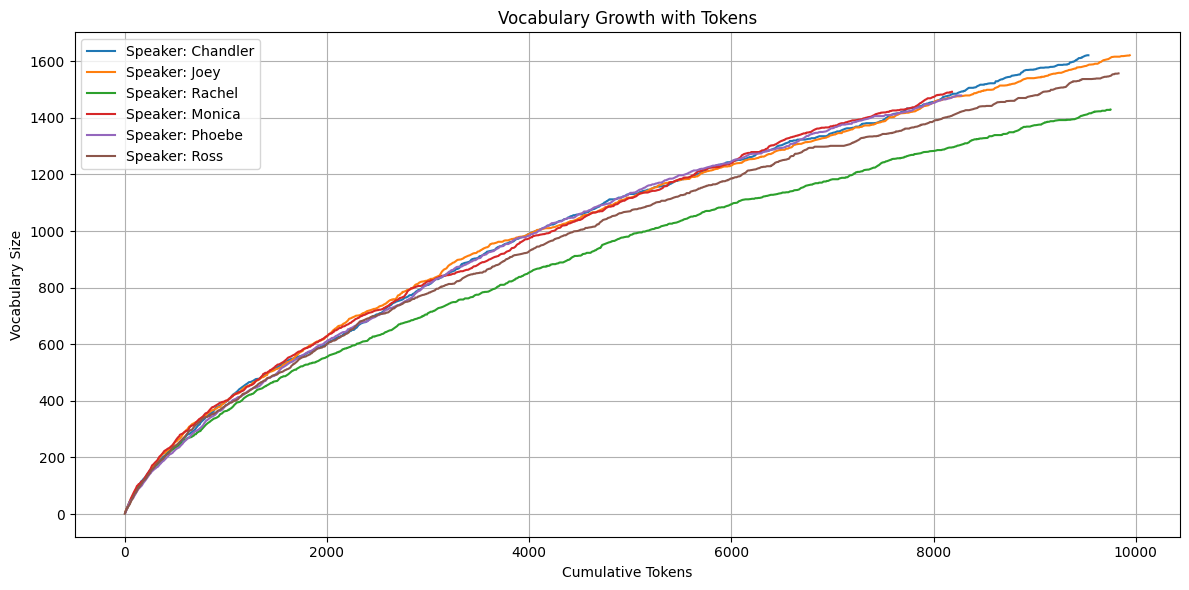

Speaker: Chandler
Perplexity: 39015.536584537906


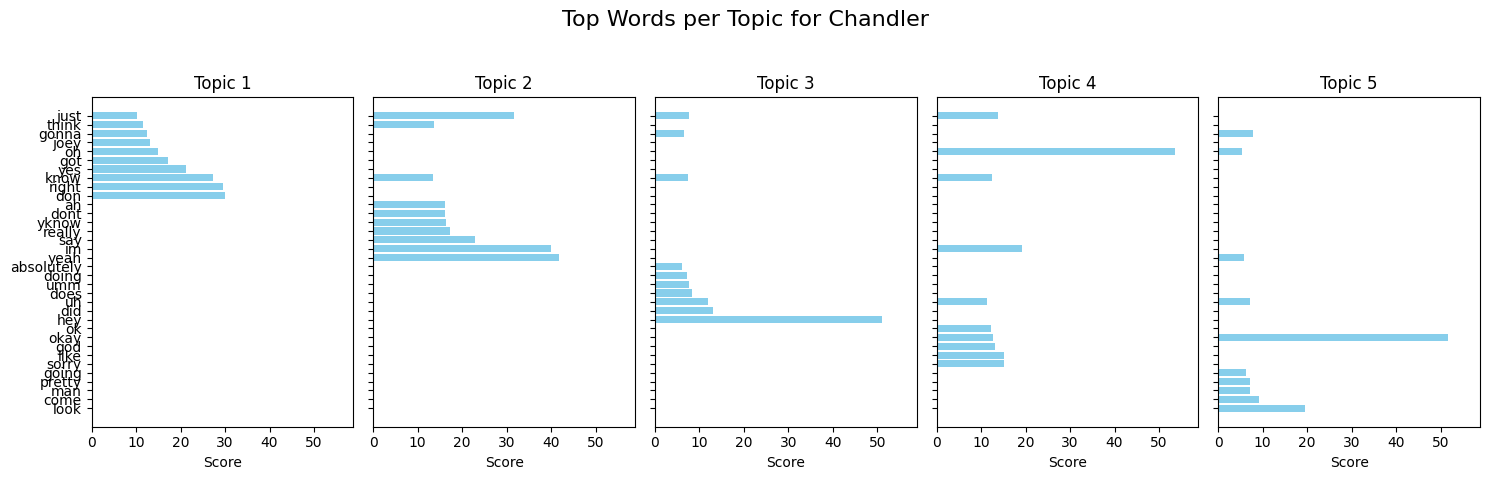

Speaker: Joey
Perplexity: 43730.26588488831


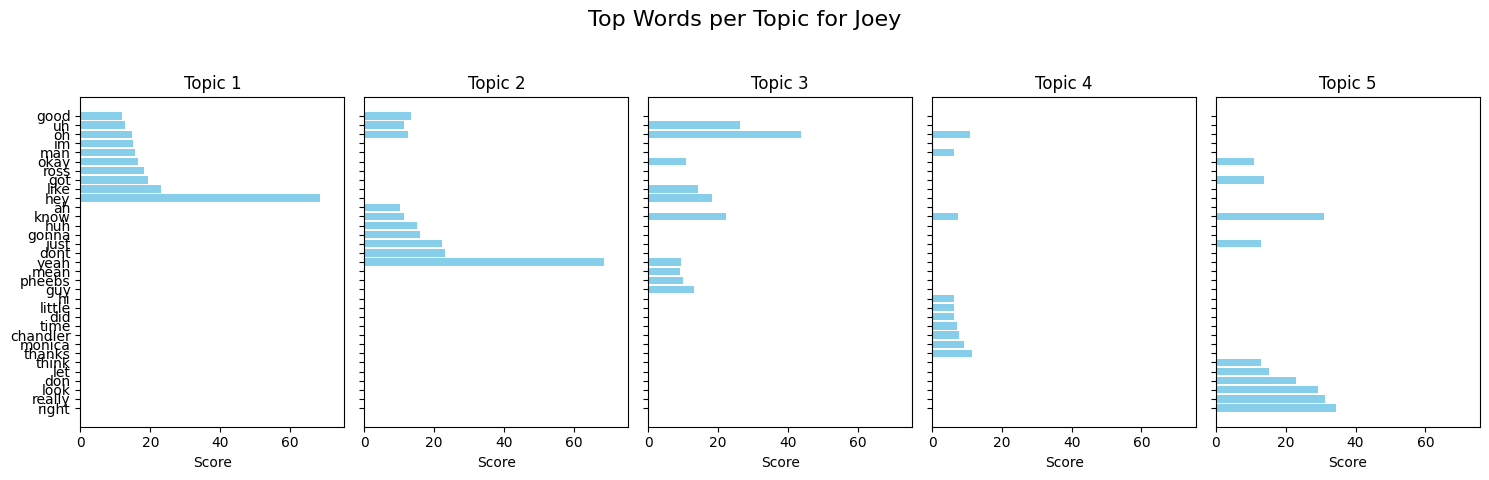

Speaker: Rachel
Perplexity: 24185.28548133433


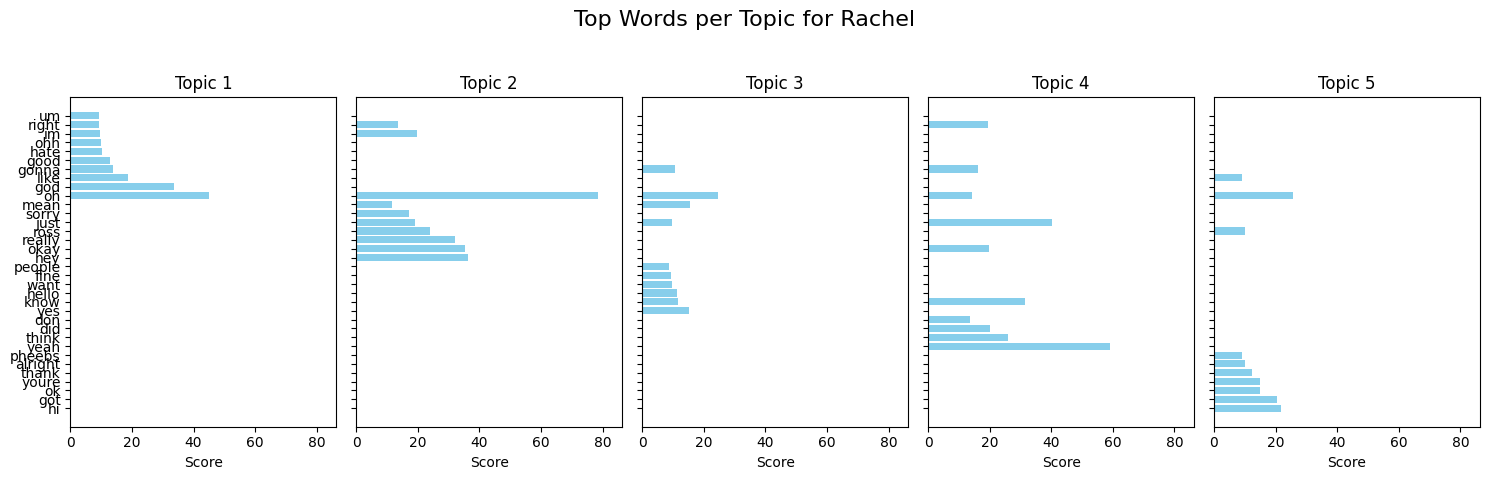

Speaker: Monica
Perplexity: 62036.45023935169


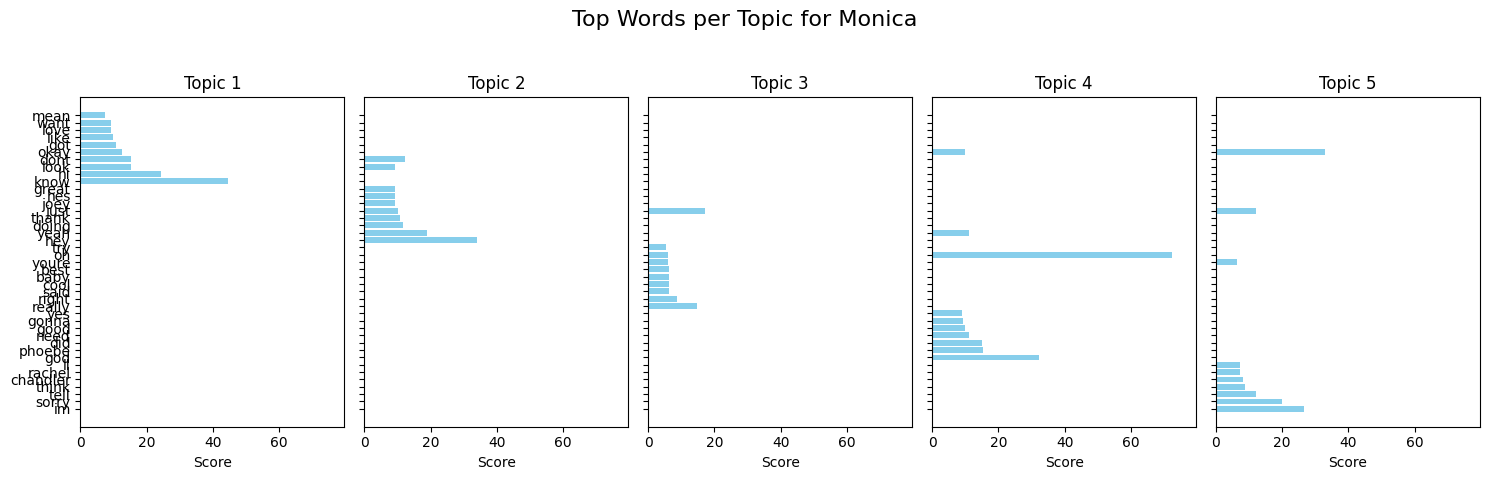

Speaker: Phoebe
Perplexity: 55371.330035048566


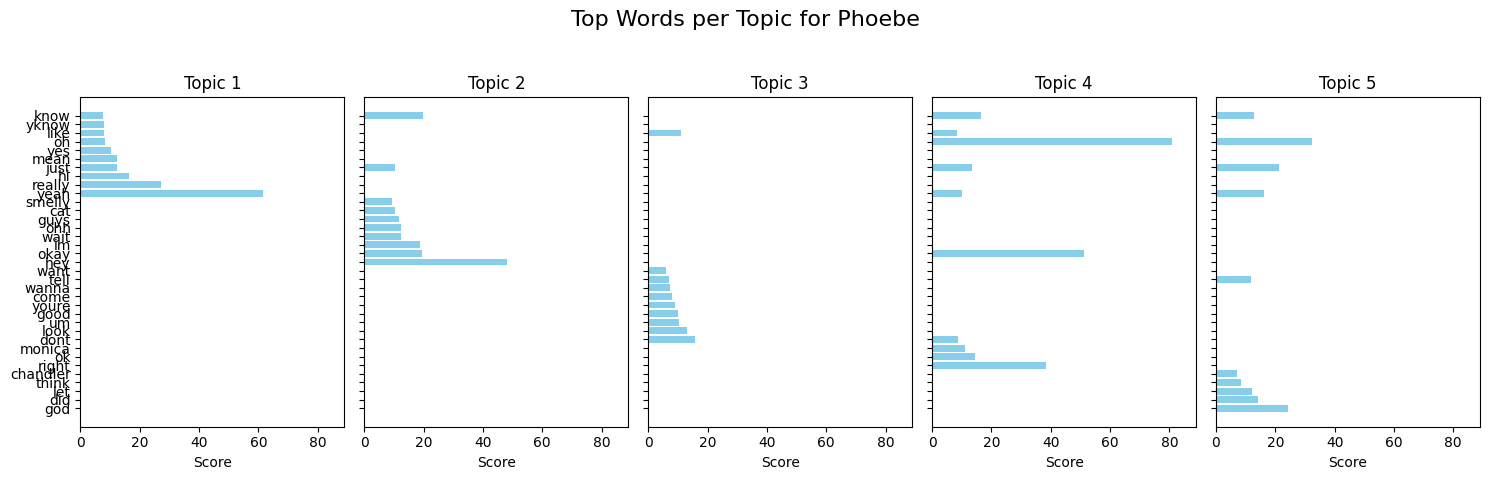

Speaker: Ross
Perplexity: 37513.50388991866


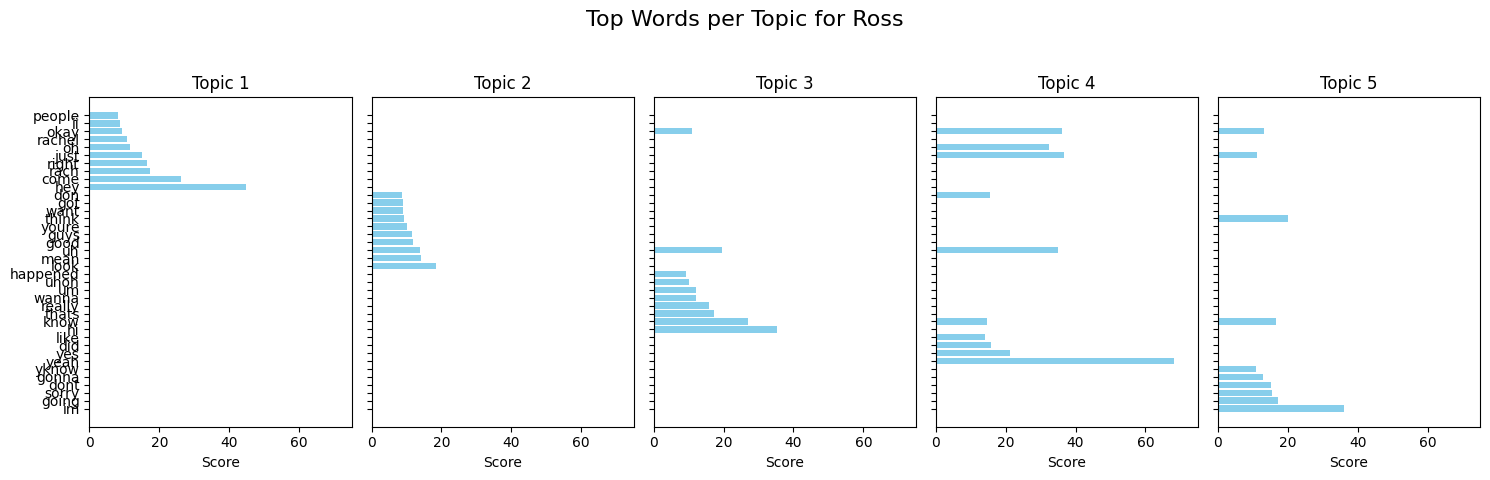

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import train_test_split

# Part 1: Vocabulary Growth per Token

# Function to calculate cumulative vocabulary growth with respect to tokens
def calculate_vocabulary_growth(speaker_df):
    cumulative_tokens = 0
    cumulative_vocabulary = set()
    vocabulary_growth = {'Tokens': [], 'Vocabulary': []}

    for _, row in speaker_df.iterrows():
        tokens = row['Tokens']
        cumulative_tokens += len(tokens)
        
        # Update vocabulary with new tokens
        cumulative_vocabulary.update(tokens)
        vocabulary_size = len(cumulative_vocabulary)

        # Append cumulative data
        vocabulary_growth['Tokens'].append(cumulative_tokens)
        vocabulary_growth['Vocabulary'].append(vocabulary_size)

    return pd.DataFrame(vocabulary_growth)

# Plot vocabulary growth for each speaker
plt.figure(figsize=(12, 6))
for speaker, speaker_df in speaker_dfs.items():
    vocab_growth_df = calculate_vocabulary_growth(speaker_df)
    plt.plot(vocab_growth_df['Tokens'], vocab_growth_df['Vocabulary'], label=f'Speaker: {speaker}')
    
plt.title(f'Vocabulary Growth with Tokens')
plt.xlabel('Cumulative Tokens')
plt.ylabel('Vocabulary Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Part 2: LDA Topic Modeling and Plotting

# Function to perform LDA topic modeling and return topics
def lda_topic_modeling(tokens_list, num_topics=5):
    # Join tokens into a single string for each document
    preprocessed_text = [' '.join(tokens) for tokens in tokens_list]
    
    # Create CountVectorizer
    vectorizer = CountVectorizer(stop_words='english')
    count_data = vectorizer.fit_transform(preprocessed_text)

    # Split the data into train and test sets
    X_train, X_test = train_test_split(count_data, test_size=0.2, random_state=42)
    
    # Create an LDA model
    lda = LDA(n_components=num_topics, random_state=42)
    lda.fit(X_train)

    # Evaluate model using perplexity
    perplexity = lda.perplexity(X_test)
    
    # Get feature names for interpreting topics
    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(lda.components_):
        topics[f"Topic {idx+1}"] = [(feature_names[i], topic[i]) for i in topic.argsort()[-10:]]

    return perplexity, topics


def plot_lda_topics(topics, speaker):
    num_topics = len(topics)
    fig, axes = plt.subplots(1, num_topics, figsize=(15, 5), sharey=True)
    fig.suptitle(f"Top Words per Topic for {speaker}", fontsize=16)

    # Collect max score for consistent x-axis limits
    max_score = max(max([score for _, score in words]) for words in topics.values())

    for idx, (topic, words) in enumerate(topics.items()):
        words, scores = zip(*words)
        axes[idx].barh(words, scores, color='skyblue')
        axes[idx].set_title(topic)
        axes[idx].invert_yaxis()  # Top words at the top of the plot
        axes[idx].set_xlim(0, max_score * 1.1)  # Set x-axis limits for consistency
        axes[idx].set_xlabel('Score')
        axes[idx].tick_params(axis='y', labelsize=10)  # Adjust y-axis font size

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



# Applying LDA and plotting for each speaker
for speaker, speaker_df in speaker_dfs.items():
    tokens_list = speaker_df['Tokens'].tolist()  # Get list of tokens for the speaker
    perplexity, topics = lda_topic_modeling(tokens_list)
    
    print(f"Speaker: {speaker}")
    print("Perplexity:", perplexity)
    plot_lda_topics(topics, speaker)



In [ ]:
nrc_lexicon = pd.read_csv("NRC_EmoLex_NRC-VAD-Lexicon.txt", sep='\t', header=None, names=['Word', 'Valence', 'Arousal', 'Dominance'])

results = {}

def calculate_vad_statistics(speaker_df):
    all_tokens = [token for tokens in speaker_df['Tokens'] for token in tokens]
    
    # Filter the NRC lexicon to get only the terms present in the speaker's tokens
    speaker_terms = nrc_lexicon[nrc_lexicon['Word'].isin(all_tokens)]
    
    if not speaker_terms.empty:
        results[speaker_df['Speaker'].iloc[0]] = {
            'Valence_Avg': speaker_terms['Valence'].mean(),
            'Arousal_Avg': speaker_terms['Arousal'].mean(),
            'Dominance_Avg': speaker_terms['Dominance'].mean(),
            'Valence_Std': speaker_terms['Valence'].std(),
            'Arousal_Std': speaker_terms['Arousal'].std(),
            'Dominance_Std': speaker_terms['Dominance'].std(),
            'Valence_Min': speaker_terms['Valence'].min(),
            'Arousal_Min': speaker_terms['Arousal'].min(),
            'Dominance_Min': speaker_terms['Dominance'].min(),
            'Valence_Max': speaker_terms['Valence'].max(),
            'Arousal_Max': speaker_terms['Arousal'].max(),
            'Dominance_Max': speaker_terms['Dominance'].max(),
            'Num_Lexicon_Terms': speaker_terms.shape[0]
        }


def calculate_emotion_patterns(speaker_df, nrc_vad_df):
    vad_scores = {'Valence': [], 'Arousal': [], 'Dominance': []}

    for tokens in speaker_df['Tokens']:
        for token in tokens:
            if token in nrc_vad_df.index:
                vad_scores['Valence'].append(nrc_vad_df.loc[token, 'Valence'])
                vad_scores['Arousal'].append(nrc_vad_df.loc[token, 'Arousal'])
                vad_scores['Dominance'].append(nrc_vad_df.loc[token, 'Dominance'])

    results = {
        'Valence': {
            'Mean': np.mean(vad_scores['Valence']),
            'Std': np.std(vad_scores['Valence']),
            'Min': np.min(vad_scores['Valence']),
            'Max': np.max(vad_scores['Valence'])
        },
        'Arousal': {
            'Mean': np.mean(vad_scores['Arousal']),
            'Std': np.std(vad_scores['Arousal']),
            'Min': np.min(vad_scores['Arousal']),
            'Max': np.max(vad_scores['Arousal'])
        },
        'Dominance': {
            'Mean': np.mean(vad_scores['Dominance']),
            'Std': np.std(vad_scores['Dominance']),
            'Min': np.min(vad_scores['Dominance']),
            'Max': np.max(vad_scores['Dominance'])
        }
    }

    return results


for speaker, speaker_df in speaker_dfs.items():
    speaker_df['Speaker'] = speaker  # Add a speaker column for reference
    calculate_vad_statistics(speaker_df)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
results_df

In [ ]:
# Insights on personality traits based on VAD scores
for speaker in results_df.index:
    valence = results_df.loc[speaker, 'Valence_Avg']
    arousal = results_df.loc[speaker, 'Arousal_Avg']
    dominance = results_df.loc[speaker, 'Dominance_Avg']
    
    # Example of commenting
    if valence < 0.5 and arousal < 0.45:
        print(f"{speaker} tends to exhibit negative emotions and low energy, possibly indicating traits like introversion.")
    elif valence > 0.5 and arousal > 0.45:
        print(f"{speaker} tends to exhibit positive emotions and high energy, possibly indicating traits like extraversion.")
